# Khanh Truong - Coline Merlen (Web Mining | March 2019)

In [1]:
%matplotlib inline
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from datetime import datetime
import pickle

# Graph Approach

In [2]:
g = nx.read_adjlist('fake-news-prediction-toulouse/data_competition/UserUser.txt')

In [3]:
print('Number of nodes: {}'.format(len(g.node)))
print('Number of edges: {}'.format(len(g.edges)))

Number of nodes: 23865
Number of edges: 408824


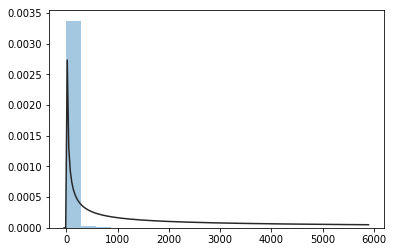

In [4]:
deg = nx.degree(g)
df = pd.Series([y for (x,y) in deg])
sns.distplot(df, bins=20, kde=False, fit=stats.powerlaw)
plt.show()

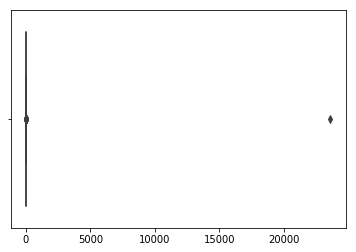

In [5]:
cc = [len(c) for c in sorted(nx.connected_components(g), key=len, reverse=True)]
sns.boxplot(cc)
plt.show()

In [6]:
largest_cc = max(nx.connected_component_subgraphs(g), key=len)

### Prediction

In [7]:
# Import label data
label = pd.read_csv('fake-news-prediction-toulouse/data_competition/labels_training.txt', sep=',')
label.columns = ['news', 'fake']
label.head()

,news,fake
0,1,0
1,3,0
2,5,0
3,6,0
4,8,0


In [9]:
# Split into train and test sets
label_train, label_test = train_test_split(label, test_size=0.2, random_state=1234)

print('% fake in whole set: {}'.format(label.fake.mean()))
print('% fake in train set: {}'.format(label_train.fake.mean()))

# From now on, only label_train is used to train the model.

% fake in whole set: 0.5025906735751295
% fake in train set: 0.4935064935064935


In [10]:
# Import news user data
news_user = pd.read_csv('fake-news-prediction-toulouse/data_competition/newsUser.txt', sep='\t', header=None)
news_user.columns = ['news', 'user', 'time']

# Merge label to news user
news_user_label = news_user.merge(label_train, left_on='news', right_on='news', how='left', copy=False)
news_user_label = news_user_label[~news_user_label.fake.isnull()] # not NA in column fake (have label)
news_user_label['fake_count'] = news_user_label['fake']*news_user_label['time'] # fake scaled by the times of posting
news_user_label.head()

,news,user,time,fake,fake_count
0,240,1,1,1.0,1.0
2,162,3,1,1.0,1.0
3,233,4,1,1.0,1.0
4,50,5,1,0.0,0.0
6,227,7,1,1.0,1.0


In [11]:
# Calculate percentage fake news posted by each user
user_fake_percent = news_user_label.groupby('user').agg({'time':'sum', # for each user, calculate total posting
                                                         'fake_count':'sum'}) # calculate total fake
user_fake_percent.columns = ['news_count','fake_count']
user_fake_percent['fake_percent'] = user_fake_percent['fake_count']/user_fake_percent['news_count'] # percentage of fake
user_fake_percent.sort_values(['fake_percent','news_count'], ascending=False, inplace=True) # sort value
user_fake_percent.head()

,news_count,fake_count,fake_percent
user,,,
19924,67,67.0,1.0
13973,45,45.0,1.0
8040,41,41.0,1.0
9584,40,40.0,1.0
4715,35,35.0,1.0


C:\Users\truong_ph\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


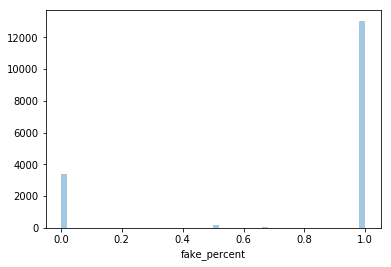

In [12]:
sns.distplot(user_fake_percent['fake_percent'], kde=False);

In [13]:
# Define fake_source, which are users who always post fake news
fake_source = user_fake_percent[user_fake_percent['fake_percent']==1].index
fake_source

Int64Index([19924, 13973,  8040,  9584,  4715,  8170,  8378, 12526, 18542,
            19590,
            ...
            23852, 23853, 23854, 23855, 23857, 23858, 23860, 23861, 23864,
            23865],
           dtype='int64', name='user', length=13040)

In [14]:
# Load DBSCAN
with open('Temporary_Files/degree.pickle', 'rb') as handle:
    degree = pickle.load(handle)
    
with open('Temporary_Files/closeness.pickle', 'rb') as handle:
    closeness = pickle.load(handle)

with open('Temporary_Files/eigenvector.pickle', 'rb') as handle:
    eigenvector = pickle.load(handle)

with open('Temporary_Files/katz.pickle', 'rb') as handle:
    katz = pickle.load(handle)

with open('Temporary_Files/betweenness.pickle', 'rb') as handle:
    betweenness = pickle.load(handle)    

In [15]:
centrality = pd.concat([pd.Series(degree),
                        pd.Series(closeness),
                        pd.Series(eigenvector),
                        pd.Series(katz),
                        pd.Series(betweenness)],
                      axis=1)

centrality.columns = ['degree' ,'closeness', 'eigenvector', 'katz', 'betweenness']
centrality.index = centrality.index.astype(int)
centrality.index.name = 'user'
centrality.head()

,degree,closeness,eigenvector,katz,betweenness
user,,,,,
507,0.000461,0.313734,0.000146,0.006121,0.000242
1,0.000335,0.290649,0.000788,-0.002283,0.000003
1589,0.009261,0.339624,0.018251,-0.023112,0.000062
5307,0.000796,0.327333,0.002286,-0.001020,0.000022
11421,0.004903,0.341899,0.018435,-0.007095,0.000020


In [16]:
user_profile = user_fake_percent.merge(centrality, left_index=True, right_index=True, how='left')
user_profile.head()

,news_count,fake_count,fake_percent,degree,closeness,eigenvector,katz,betweenness
user,,,,,,,,
19924,67,67.0,1.0,0.002598,0.323971,0.000341,-0.007398,1.546011e-04
13973,45,45.0,1.0,0.000419,0.316620,0.001459,0.002687,3.008375e-07
8040,41,41.0,1.0,0.002682,0.373787,0.001328,0.004691,1.939276e-04
9584,40,40.0,1.0,0.003185,0.380828,0.010665,0.021683,1.048820e-04
4715,35,35.0,1.0,0.000126,0.326341,0.000212,-0.000878,2.024279e-05


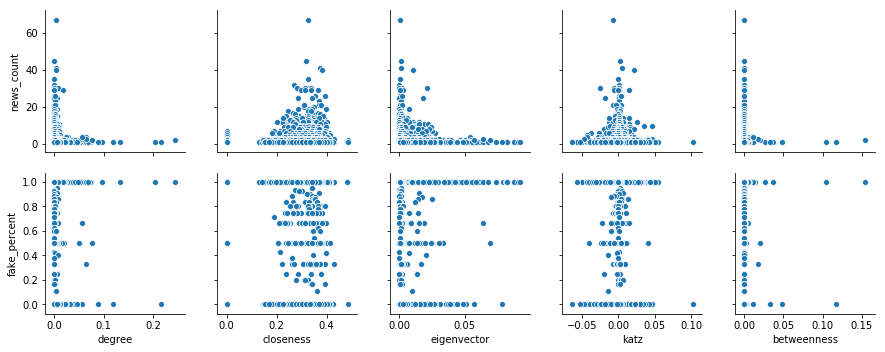

In [18]:
sns.pairplot(user_profile,
             x_vars = ['degree', 'closeness', 'eigenvector', 'katz', 'betweenness'],
             y_vars = ['news_count', 'fake_percent']);
# There seem no relationship between fake_percent|news_count and the node centrality measures

In [179]:
train_pred = label_train \
    .merge(news_user, left_on='news', right_on='news', how='left') \
    .merge(user_profile[['fake_percent']], left_on='user', right_index=True, how='left') \
    .groupby('news').agg({'fake_percent':np.mean}) \
    .rename(columns={'fake_percent':'fake_score'}) \
    .merge(label_train, left_index=True, right_on='news', how='left') \
    .set_index('news')
train_pred.head()

,fake_score,fake
news,,
1,0.115000,0
3,0.172075,0
5,0.080952,0
6,0.179170,0
8,0.100639,0


In [178]:
test_pred = label_test \
    .merge(news_user, left_on='news', right_on='news', how='left') \
    .merge(user_profile[['fake_percent']], left_on='user', right_index=True, how='left') \
    .groupby('news').agg({'fake_percent':np.mean}) \
    .rename(columns={'fake_percent':'fake_score'}) \
    .merge(label_test, left_index=True, right_on='news', how='left') \
    .set_index('news')
test_pred.head()

,fake_score,fake
news,,
9,0.100639,0
10,0.125000,0
11,0.202590,0
13,0.477073,0
38,0.666667,0


In [182]:
threshold = []
f_measure_train = []
f_measure_test = []

for threshold_i in np.linspace(0, 1, 101):

    f_measure_train_i = f1_score(y_true=train_pred['fake'],
                                 y_pred=train_pred.apply(lambda x: 1 if x.fake_score>threshold_i else 0,axis=1))
    
    f_measure_test_i = f1_score(y_true=test_pred['fake'],
                                y_pred=test_pred.apply(lambda x: 1 if x.fake_score>threshold_i else 0,axis=1))
    
    f_measure_train.append(f_measure_train_i)
    f_measure_test.append(f_measure_test_i)
    threshold.append(threshold_i)
    
f_measure = pd.DataFrame([threshold, f_measure_train, f_measure_test]).transpose()
f_measure.columns = ['threshold' , 'f_measure_train', 'f_measure_test']
f_measure.set_index('threshold', inplace=True)
f_measure.head()

C:\Users\truong_ph\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\truong_ph\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,f_measure_train,f_measure_test
threshold,,
0.00,0.703704,0.689655
0.01,0.734300,0.701754
0.02,0.763819,0.701754
0.03,0.783505,0.727273
0.04,0.804233,0.740741


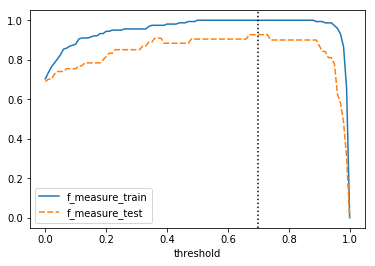

In [183]:
sns.lineplot(data=f_measure)
plt.axvline(x=0.7, color='black', linestyle=':');
# choose threshold 0.7 

### For submission

In [192]:
# Merge label to news user
news_user_label = news_user.merge(label, left_on='news', right_on='news', how='left', copy=False)
news_user_label = news_user_label[~news_user_label.fake.isnull()] # not NA in column fake (have label)
news_user_label['fake_count'] = news_user_label['fake']*news_user_label['time'] # fake scaled by the times of posting

# Calculate percentage fake news posted by each user
user_fake_percent = news_user_label.groupby('user').agg({'time':'sum', # for each user, calculate total posting
                                                         'fake_count':'sum'}) # calculate total fake
user_fake_percent.columns = ['news_count','fake_count']
user_fake_percent['fake_percent'] = user_fake_percent['fake_count']/user_fake_percent['news_count'] # percentage of fake
user_fake_percent.sort_values(['fake_percent','news_count'], ascending=False, inplace=True) # sort value

# Calculate news fake score
final_pred = news_user.merge(label, left_on='news', right_on='news', how='left', copy=False)
final_pred = final_pred \
    .loc[final_pred.fake.isnull(),:] \
    .merge(user_fake_percent[['fake_percent']], left_on='user', right_index=True, how='left') \
    .groupby('news').agg({'fake_percent':np.mean}) \
    .rename(columns={'fake_percent':'fake_score'})

# Calculate fake prediction
final_pred['fake_pred'] = final_pred.apply(lambda x: 1 if x.fake_score>0.7 else 0,axis=1)

final_pred.head()

,fake_score,fake_pred
news,,
2,0.246488,0
4,0.303571,0
7,0.252778,0
16,0.032407,0
17,0.135556,0
